<h2>Creazione modello SARIMA mensile sui decessi registrati in 7357 comuni italiani rispetto a un totale di comuni di 7904

<p>Il DataSet utilizzato contiene i dati relativi al totale dei decessi giornalieri rigistrati dall'ISTAT dal <b>1 gennaio 2015 </b> al <b>30 giugno 2020</b>.
    </p>

In [7]:
import pandas as pd
df = pd.read_csv('../csv/serie_storica.csv')
df.head()

,DATA,TOTALE
0,2015-01-01,2508
1,2015-01-02,2079
2,2015-01-03,2107
3,2015-01-04,2135
4,2015-01-05,2199


In [8]:
df['DATA'] = pd.to_datetime(df['DATA'])

<h2>Creazione serie storica mensile

In [9]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-01,2508
2015-01-02,2079
2015-01-03,2107
2015-01-04,2135
2015-01-05,2199


In [11]:
df = df.groupby(pd.Grouper(freq='M')).sum()
df.head(10)

,TOTALE
DATA,
2015-01-31,64887
2015-02-28,57787
2015-03-31,57102
2015-04-30,50906
2015-05-31,48055
2015-06-30,45771
2015-07-31,55601
2015-08-31,48509
2015-09-30,44766


In [12]:
ts = df.TOTALE
ts.head()

DATA
2015-01-31    64887
2015-02-28    57787
2015-03-31    57102
2015-04-30    50906
2015-05-31    48055
Freq: M, Name: TOTALE, dtype: int64

<h2>Visualizzazione della serie storica

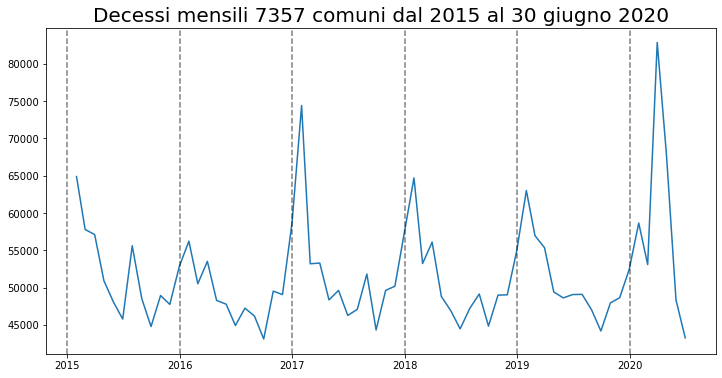

In [15]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi mensili 7357 comuni dal 2015 al 30 giugno 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposizione

Attraverso la funzione `seasonal_decompose()` la serie storica viene decomposta in <b>trend</b>, <b>stagionalità</b> e <b>residui</b>. 

Tramite questo processo è possibile visionare più nel dettaglio l'andamento della serie storica esaminata, con lo scopo d'impiegare le informazioni acquisite per la creazione di un valido modello predittivo. 

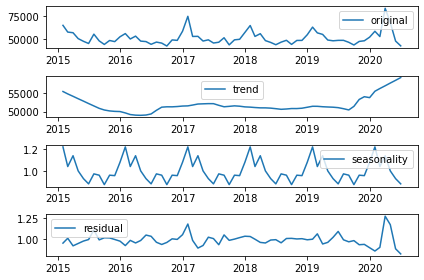

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2>Test stazionario

La modellazione di una serie storica è possibile solo se la serie è <b>stazionaria</b>, ovvero quando le sue proprietà statistiche non variano nel tempo.

La funzione `test_stationarity()` verifica che la serie storica sia stazionaria o meno attraverso il calcolo della <b>Rolling Statistic</b> e del <b>Dickey-Fuller test</b>.

In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

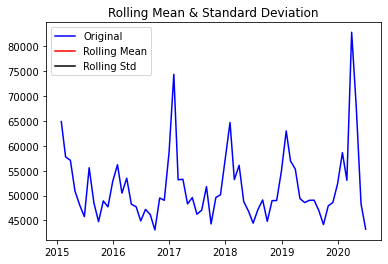

Results of Dickey-Fuller Test:
Test Statistic                 -4.980612
p-value                         0.000024
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64
X is stationary


True

In [18]:
test_stationarity(ts)

<h2>Suddivisione della serie storica in train e test

Per poter costruire un modello predittivo è necessario suddividere la <b>serie storica </b> in `train` e `test`. 
<br />
La parte di `train`, che va dal <b>1 gennaio 2015</b> al <b>31 ottobre 2019</b>, sarà impiegata per l'allenamento del modello.
<br />
La parte di `test`, che va dal <b>1 novembre 2019</b> al <b>31 dicembre 2019</b>, sarà impiegata invece per testare la precisione di predizione del modello creato, andando a confrontare la predizione ottenuta con i valori originali della parte `test`.

In [23]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

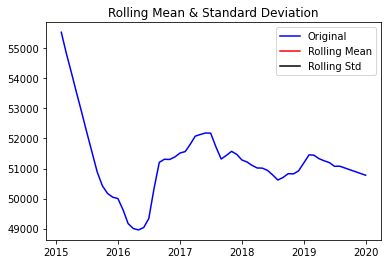

Results of Dickey-Fuller Test:
Test Statistic                 -4.786876
p-value                         0.000058
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
X is stationary
0


In [24]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h2>Autocorrelazione e Autocorrelazione Parziale

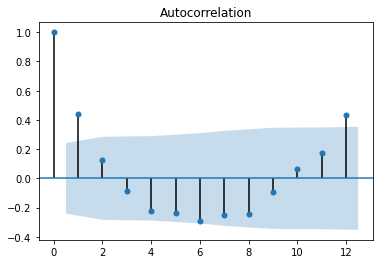

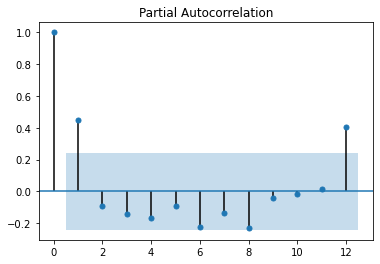

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h1>CREAZIONE DEL MODELLO

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(12,0,8))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   58
Model:              SARIMAX(12, 0, 8)   Log Likelihood                -566.675
Date:                Wed, 18 Nov 2020   AIC                           1175.350
Time:                        14:33:07   BIC                           1218.620
Sample:                    01-31-2015   HQIC                          1192.205
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0784      0.085     -0.921      0.357      -0.245       0.088
ar.L2          0.1403      0.110      1.280      0.201      -0.075       0.355
ar.L3          0.1213      0.112      1.083      0.2

<h2>Verifica che i residui del modello siano stazionari

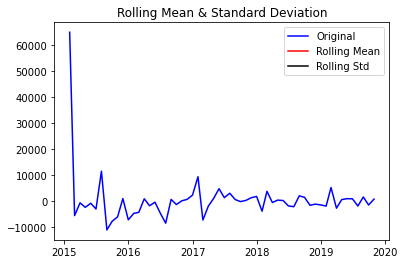

Results of Dickey-Fuller Test:
Test Statistic                -19.704834
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is stationary


True

In [29]:
residuals = model_fit.resid
test_stationarity(residuals)

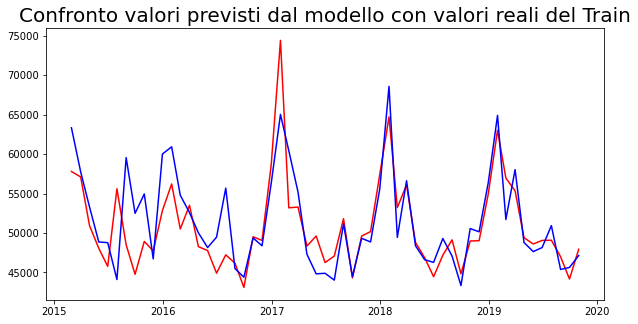

In [30]:
plt.figure(figsize=(10,5))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

<h2>Intervallo di confidenza del modello 

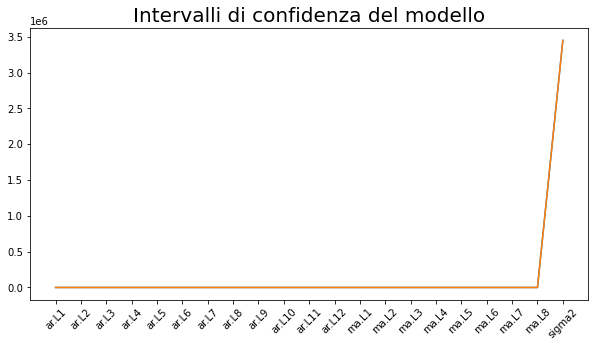

In [31]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h2>Predizione del modello sul test

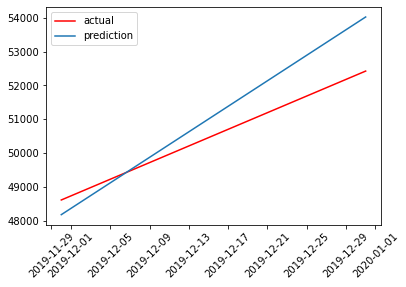

2019-11-30    48191.087584
2019-12-31    54019.803424
Freq: M, Name: predicted_mean, dtype: float64


In [32]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

#pred_start= len(train)
#pred_end = len(tsb)
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

<h2>Calcolo RMSE

In [96]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.30742059863501564


<h2>Predizione totale

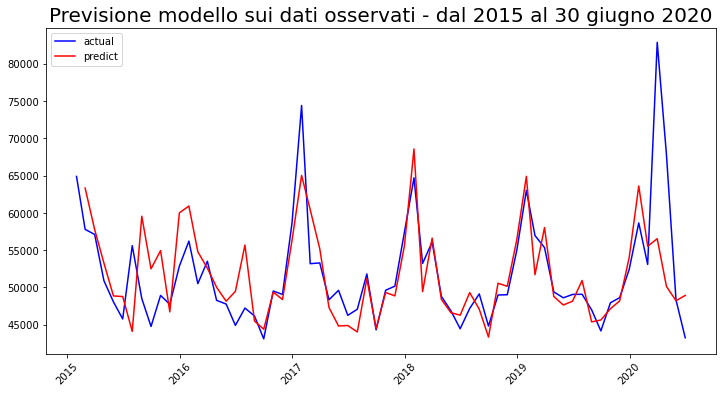

In [33]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello sui dati osservati - dal 2015 al 30 giugno 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

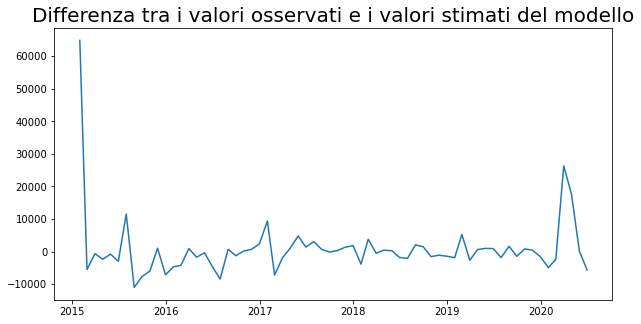

In [34]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [35]:
diff_predictions_tot['24-02-2020':].sum()

35997.35121582612

In [43]:
predictions_tot.to_csv('../csv/predictions_SARIMA_7357comuni.csv')

<h2>Intervalli di confidenza

In [39]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2015-01-31        0.000000
2015-02-28    63323.839318
2015-03-31    57750.837865
2015-04-30    53269.209918
2015-05-31    48857.560687
                  ...     
2020-02-29    55518.229040
2020-03-31    56534.933750
2020-04-30    50129.783354
2020-05-31    48220.554311
2020-06-30    48927.148330
Freq: M, Name: predicted_mean, Length: 66, dtype: float64
            lower TOTALE  upper TOTALE
2015-01-31 -90666.572140  90666.572140
2015-02-28  43542.591479  83105.087156
2015-03-31  38223.381928  77278.293801
2015-04-30  34852.892753  71685.527083
2015-05-31  30678.234910  67036.886463
...                  ...           ...
2020-02-29  50860.035361  60176.422718
2020-03-31  51876.686231  61193.181268
2020-04-30  45437.931803  54821.634905
2020-05-31  42593.231441  53847.877181
2020-06-30  43147.030748  54707.265912

[66 rows x 2 columns]
2015-01-31    90666.572140
2015-02-28    19781.247839
2015-03-31    19527.455937
2015-04-30    18416.317165
2015-05-31    18179.325776
                  .

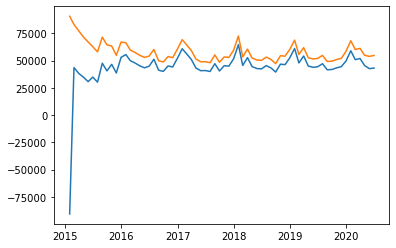

In [40]:
plt.plot(in_c)
plt.show()

In [41]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [42]:
lower.to_csv('../csv/predictions_SARIMA_lower.csv')
upper.to_csv('../csv/predictions_SARIMA_upper.csv')